# First attempt on a classifier discriminating ttbar and ttW

We can't train on just SS because the rate is too low.

In [1]:
import uproot
import awkward
import numpy as np
import pandas as pd
from uproot_methods import TLorentzVectorArray

from coffea.processor import LazyDataFrame
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (typ

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_hdf('data/data_X.h5') # load data processed with ML_processor.py

sig_df = df[df['signal']==1]
bkg_df = df[df['signal']==0]

# usually we have less signal than background
nSmall = len(sig_df) if len(sig_df) < len(bkg_df) else len(bkg_df)

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSmall )
tmp_sig_df = sig_df.sample( n = nSmall )

y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

print ("The smaller data set contains %s events"%nSmall)

# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.9*y_tmp.shape[0] ), random_state=42 )

variables = ['mll', 'njet', 'nbtag', 'st', 'ht', 'met', 'mjj_max', 'mlb_min', 'mlb_max', 'l0_pt', 'l1_pt', 'deltaR_lj_min', 'j0_pt']
#variables = ['njet', 'st', 'ht']
#variables = ['mll', 'st', 'ht', 'met', 'mjj_max', 'mlb_min', 'mlb_max', 'l0_pt', 'l1_pt', 'deltaR_lj_min', 'j0_pt']

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]

The smaller data set contains 14837 events


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


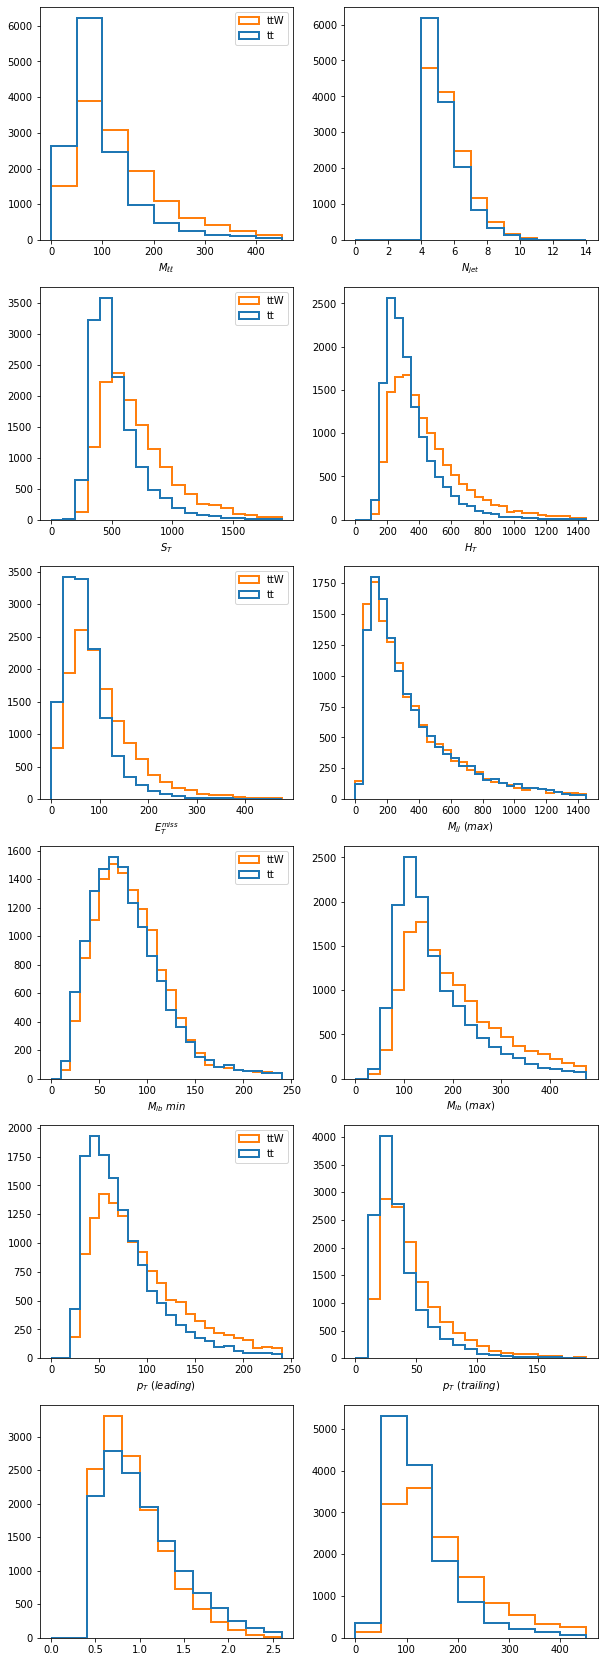

In [4]:
X_bkg = X_train[y_train==0]
X_sig = X_train[y_train==1]

fig, axs = plt.subplots(6,2, figsize=(10,30))

hist, bins, ax = axs[0,0].hist( [ X_bkg[['mll']].values, X_sig[['mll']].values ], range(0,500,50), histtype='step', linewidth=2, label=['tt', 'ttW'])
hist, bins, ax = axs[0,1].hist( [ X_bkg[['njet']].values, X_sig[['njet']].values ], range(0,15,1), histtype='step', linewidth=2) 
hist, bins, ax = axs[1,0].hist( [ X_bkg[['st']].values, X_sig[['st']].values ], range(0,2000,100), histtype='step', linewidth=2, label=['tt', 'ttW'])
hist, bins, ax = axs[1,1].hist( [ X_bkg[['ht']].values, X_sig[['ht']].values ], range(0,1500,50), histtype='step', linewidth=2) 
hist, bins, ax = axs[2,0].hist( [ X_bkg[['met']].values, X_sig[['met']].values ], range(0,500,25), histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[2,1].hist( [ X_bkg[['mjj_max']].values, X_sig[['mjj_max']].values ], range(0,1500,50), histtype='step', linewidth=2) 
hist, bins, ax = axs[3,0].hist( [ X_bkg[['mlb_min']].values, X_sig[['mlb_min']].values ], range(0,250,10), histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[3,1].hist( [ X_bkg[['mlb_max']].values, X_sig[['mlb_max']].values ], range(0,500,25), histtype='step', linewidth=2) 
hist, bins, ax = axs[4,0].hist( [ X_bkg[['l0_pt']].values, X_sig[['l0_pt']].values ], range(0,250,10), histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[4,1].hist( [ X_bkg[['l1_pt']].values, X_sig[['l1_pt']].values ], range(0,200,10), histtype='step', linewidth=2) 
hist, bins, ax = axs[5,0].hist( [ X_bkg[['deltaR_lj_min']].values, X_sig[['deltaR_lj_min']].values ], [0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6], histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[5,1].hist( [ X_bkg[['j0_pt']].values, X_sig[['j0_pt']].values ], range(0,500,50), histtype='step', linewidth=2) 

axs[0,0].set_xlabel(r'$M_{\ell\ell}$')
axs[0,1].set_xlabel(r'$N_{jet}$')
axs[1,0].set_xlabel(r'$S_{T}$')
axs[1,1].set_xlabel(r'$H_{T}$')
axs[2,0].set_xlabel(r'$E_{T}^{miss}$')
axs[2,1].set_xlabel(r'$M_{jj}~(max)$')
axs[3,0].set_xlabel(r'$M_{lb}~{min}$')
axs[3,1].set_xlabel(r'$M_{lb}~(max)$')
axs[4,0].set_xlabel(r'$p_{T}~(leading)$')
axs[4,1].set_xlabel(r'$p_{T}~(trailing)$')

axs[0,0].legend()
axs[1,0].legend()
axs[2,0].legend()
axs[3,0].legend()
axs[4,0].legend()

In [5]:
# Normalize Data - mean to 0, and std to 1 
X_mean, X_std = X_train.mean(), X_train.std()

X_train -= X_mean
X_train /= X_std

X_test -= X_mean
X_test /= X_std

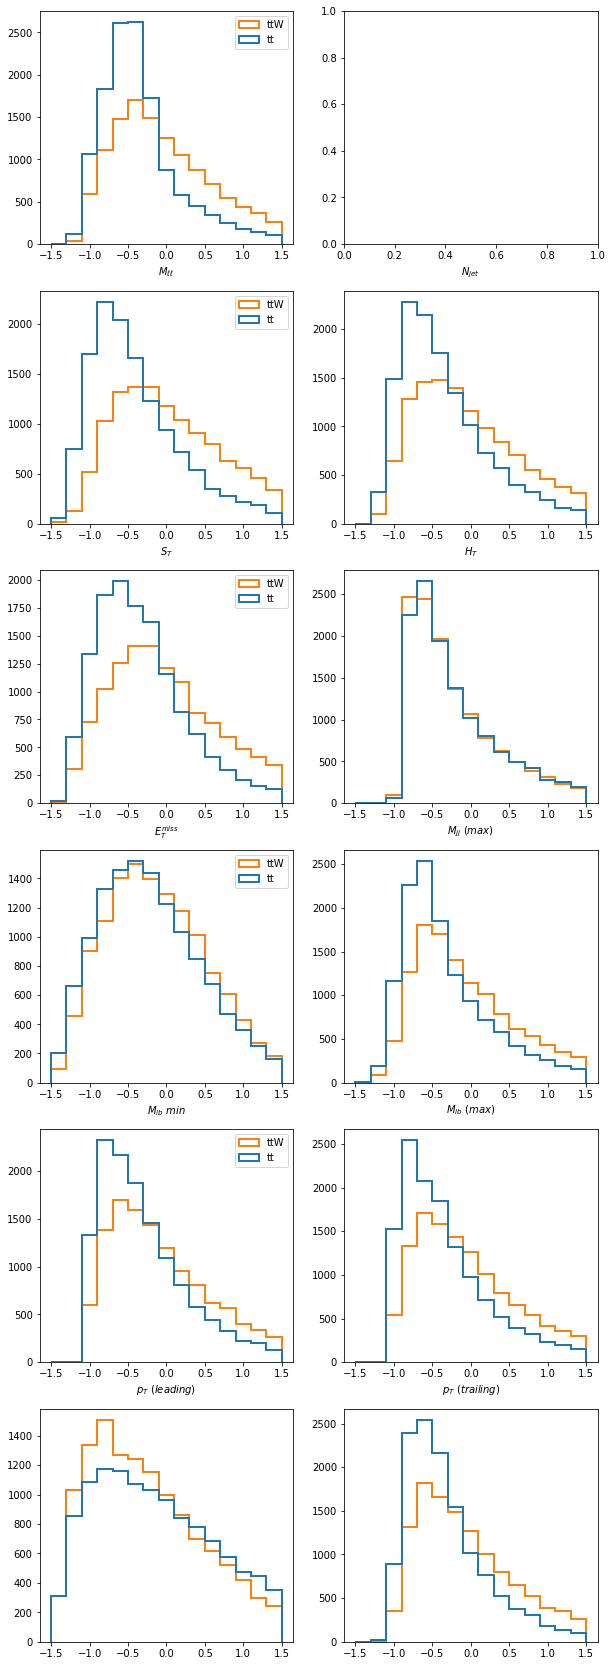

In [6]:
X_bkg = X_train[y_train==0]
X_sig = X_train[y_train==1]

fig, axs = plt.subplots(6,2, figsize=(10,30))

binning = [-1.5,-1.3,-1.1,-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5]

hist, bins, ax = axs[0,0].hist( [ X_bkg[['mll']].values, X_sig[['mll']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW'])
#hist, bins, ax = axs[0,1].hist( [ X_bkg[['njet']].values, X_sig[['njet']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[1,0].hist( [ X_bkg[['st']].values, X_sig[['st']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW'])
hist, bins, ax = axs[1,1].hist( [ X_bkg[['ht']].values, X_sig[['ht']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[2,0].hist( [ X_bkg[['met']].values, X_sig[['met']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[2,1].hist( [ X_bkg[['mjj_max']].values, X_sig[['mjj_max']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[3,0].hist( [ X_bkg[['mlb_min']].values, X_sig[['mlb_min']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[3,1].hist( [ X_bkg[['mlb_max']].values, X_sig[['mlb_max']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[4,0].hist( [ X_bkg[['l0_pt']].values, X_sig[['l0_pt']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[4,1].hist( [ X_bkg[['l1_pt']].values, X_sig[['l1_pt']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[5,0].hist( [ X_bkg[['deltaR_lj_min']].values, X_sig[['deltaR_lj_min']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[5,1].hist( [ X_bkg[['j0_pt']].values, X_sig[['j0_pt']].values ], binning, histtype='step', linewidth=2) 

axs[0,0].set_xlabel(r'$M_{\ell\ell}$')
axs[0,1].set_xlabel(r'$N_{jet}$')
axs[1,0].set_xlabel(r'$S_{T}$')
axs[1,1].set_xlabel(r'$H_{T}$')
axs[2,0].set_xlabel(r'$E_{T}^{miss}$')
axs[2,1].set_xlabel(r'$M_{jj}~(max)$')
axs[3,0].set_xlabel(r'$M_{lb}~{min}$')
axs[3,1].set_xlabel(r'$M_{lb}~(max)$')
axs[4,0].set_xlabel(r'$p_{T}~(leading)$')
axs[4,1].set_xlabel(r'$p_{T}~(trailing)$')

axs[0,0].legend()
axs[1,0].legend()
axs[2,0].legend()
axs[3,0].legend()
axs[4,0].legend()

In [23]:
epochs = 50
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Dense(units=20, activation='relu', input_dim=X_train.shape[1], ))
model.add( tf.keras.layers.Dense(units=40, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )
model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                280       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________


In [24]:
from ML.lrcurve import KerasLearningCurve

history = model.fit(X_train.values, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0, callbacks=[KerasLearningCurve()])


In [25]:
#model.save( 'data/training.h5', include_optimizer=False )
model.save_weights( 'data/training_weights.h5' )
model.save( 'data/training.h5' )

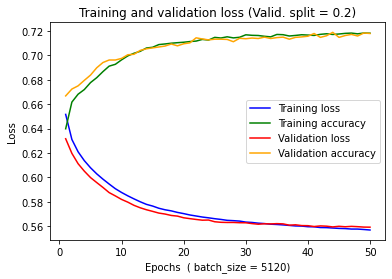

In [26]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)

plt.plot(epochslist, loss_values, 'b', label='Training loss')
plt.plot(epochslist, acc_values,'b', color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'b', color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'b', color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

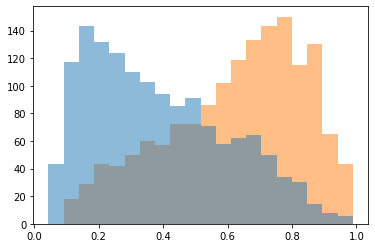

In [27]:
loaded_model = tf.keras.models.load_model('data/training.h5')

# use the model to predict whether an event is signal or background
y_test_pred = pd.DataFrame( loaded_model.predict( X_test.values  ) , index = X_test.index)

xbin = 20
hist, bins, ax = plt.hist( [ y_test_pred[y_test==0].values, y_test_pred[y_test==1].values ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

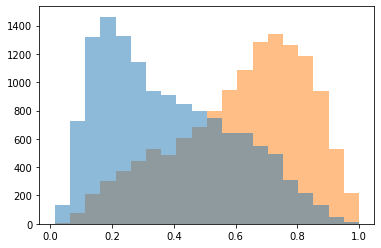

In [28]:
# use the model to predict whether an event is signal or background. this is with the training set
y_train_pred = pd.DataFrame( loaded_model.predict( X_train.values  ) , index = X_train.index)

xbin = 20
hist, bins, ax = plt.hist( [ y_train_pred[y_train==0].values, y_train_pred[y_train==1].values ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

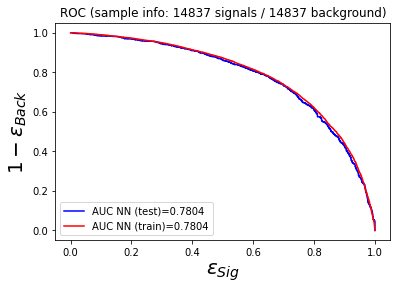

In [29]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN (test)=' + str(round(auc_val_test,4) ))


fpr_train, tpr_train, thresholds_test = roc_curve( y_train, y_train_pred )
auc_val_train = auc(fpr_test, tpr_test)

plt.plot( tpr_train, 1-fpr_train, 'r', label= 'AUC NN (train)=' + str(round(auc_val_train,4) ))


plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')


In [14]:
means = pd.DataFrame(X_mean)
with open('data/means.json', 'w') as f:
    f.write(means.to_json())

# load the data frame and convert it to a series with squeeze
means = pd.read_json('data/means.json').squeeze()

stds = pd.DataFrame(X_std)
with open('data/stds.json', 'w') as f:
    f.write(stds.to_json())

# load the data frame and convert it to a series with squeeze
stds = pd.read_json('data/stds.json').squeeze()

In [15]:
X_train.values

array([[-0.30347889, -0.88440828, -0.71472956, ..., -0.58628857,
        -0.85404272, -0.80061269],
       [-0.2429399 , -0.05871321,  1.14276048, ..., -0.54065305,
         0.72623742, -1.03409004],
       [ 0.18067318, -0.88440828, -0.71472956, ..., -0.74431014,
         0.62857412, -1.00626779],
       ...,
       [-1.01069937, -0.05871321, -0.71472956, ...,  0.17262831,
         0.79534215, -0.45699373],
       [-0.40291873, -0.88440828, -0.71472956, ..., -0.86018825,
        -0.98673335, -0.87776923],
       [ 0.40002069, -0.88440828,  1.14276048, ...,  1.16234922,
        -0.13055068, -0.51665378]])

In [16]:
y_train_pred = pd.DataFrame( model.predict( X_train.values  ) , index = X_train.index)

In [17]:
model_l = tf.keras.models.load_model('data/training.h5a')
model.predict( X_train.values  )

array([[0.25631508],
       [0.44159526],
       [0.1545674 ],
       ...,
       [0.6426603 ],
       [0.16390845],
       [0.7614361 ]], dtype=float32)

In [18]:
import pickle
#with  as f:
pickle.dump(X_train, open('test.pkl', "wb"))

In [19]:
pickle.load(open('test.pkl', 'rb'))

,mll,njet,nbtag,st,ht,met,mjj_max,mlb_min,mlb_max,l0_pt,l1_pt,deltaR_lj_min,j0_pt
32887,-0.303479,-0.884408,-0.714730,-0.759010,-0.820004,-0.570349,-0.798564,-1.171541,-0.603413,0.307077,-0.586289,-0.854043,-0.800613
155,-0.242940,-0.058713,1.142760,-0.789543,-0.955136,-0.523888,-0.174934,-0.640189,-0.422833,0.585655,-0.540653,0.726237,-1.034090
52,0.180673,-0.884408,-0.714730,-1.303783,-1.174383,-0.623056,-0.814963,-0.821982,-0.950185,-0.847655,-0.744310,0.628574,-1.006268
97,-1.038953,-0.884408,-0.714730,-0.699530,-0.346303,-0.848653,-0.529649,-1.080144,-1.117000,-0.734880,-0.816356,-0.959615,-0.343410
58492,1.615392,-0.884408,-0.714730,0.953694,0.393304,1.696784,-0.117959,0.754749,2.406307,0.919074,0.605517,0.357180,0.268105
28,0.613425,-0.058713,-0.714730,-0.898520,-0.722537,-0.703953,-0.680567,-0.390689,-0.492867,-0.614238,-0.474487,-0.570715,-0.769062
58148,-0.082571,-0.058713,1.142760,-0.595330,-0.804333,0.631935,-0.726497,-0.058801,-0.010717,-0.530647,-0.103960,-0.933295,-0.849087
2,0.195687,-0.058713,-0.714730,0.262414,0.365828,-0.068445,-0.408061,0.253754,0.147175,-0.104092,0.184360,-0.538473,0.409224
19104,1.308409,0.766982,-0.714730,1.802724,1.425733,-0.111348,0.234283,0.348905,2.539750,3.665456,-0.483425,-0.974407,2.291958
11,1.128265,-0.884408,1.142760,-0.013491,0.302232,-0.678168,-0.756458,-0.585186,1.419536,-0.515446,0.216610,-0.792459,0.481505
